In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from IPython.display import Markdown

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox, yeojohnson
from scipy import stats

In [2]:
test_df = pd.read_csv("../data/bank-additional/bank-additional-full.csv",sep=';')

In [3]:
test_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [4]:
test_df.shape

(41188, 21)

In [5]:
# check for NAs
test_df.isna().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [6]:
test_df.isin([-np.inf,np.inf]).any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [7]:
test_df[test_df == "unknown"] = np.nan
test_df = test_df.dropna()

Removing columns emp.var.rate, cons.price.idx,euribor3m and nr.employed as it is not present in the current model     

In [8]:
test_df = test_df.drop(columns=['emp.var.rate', 'cons.price.idx','euribor3m','nr.employed','cons.conf.idx','day_of_week'],axis=0)

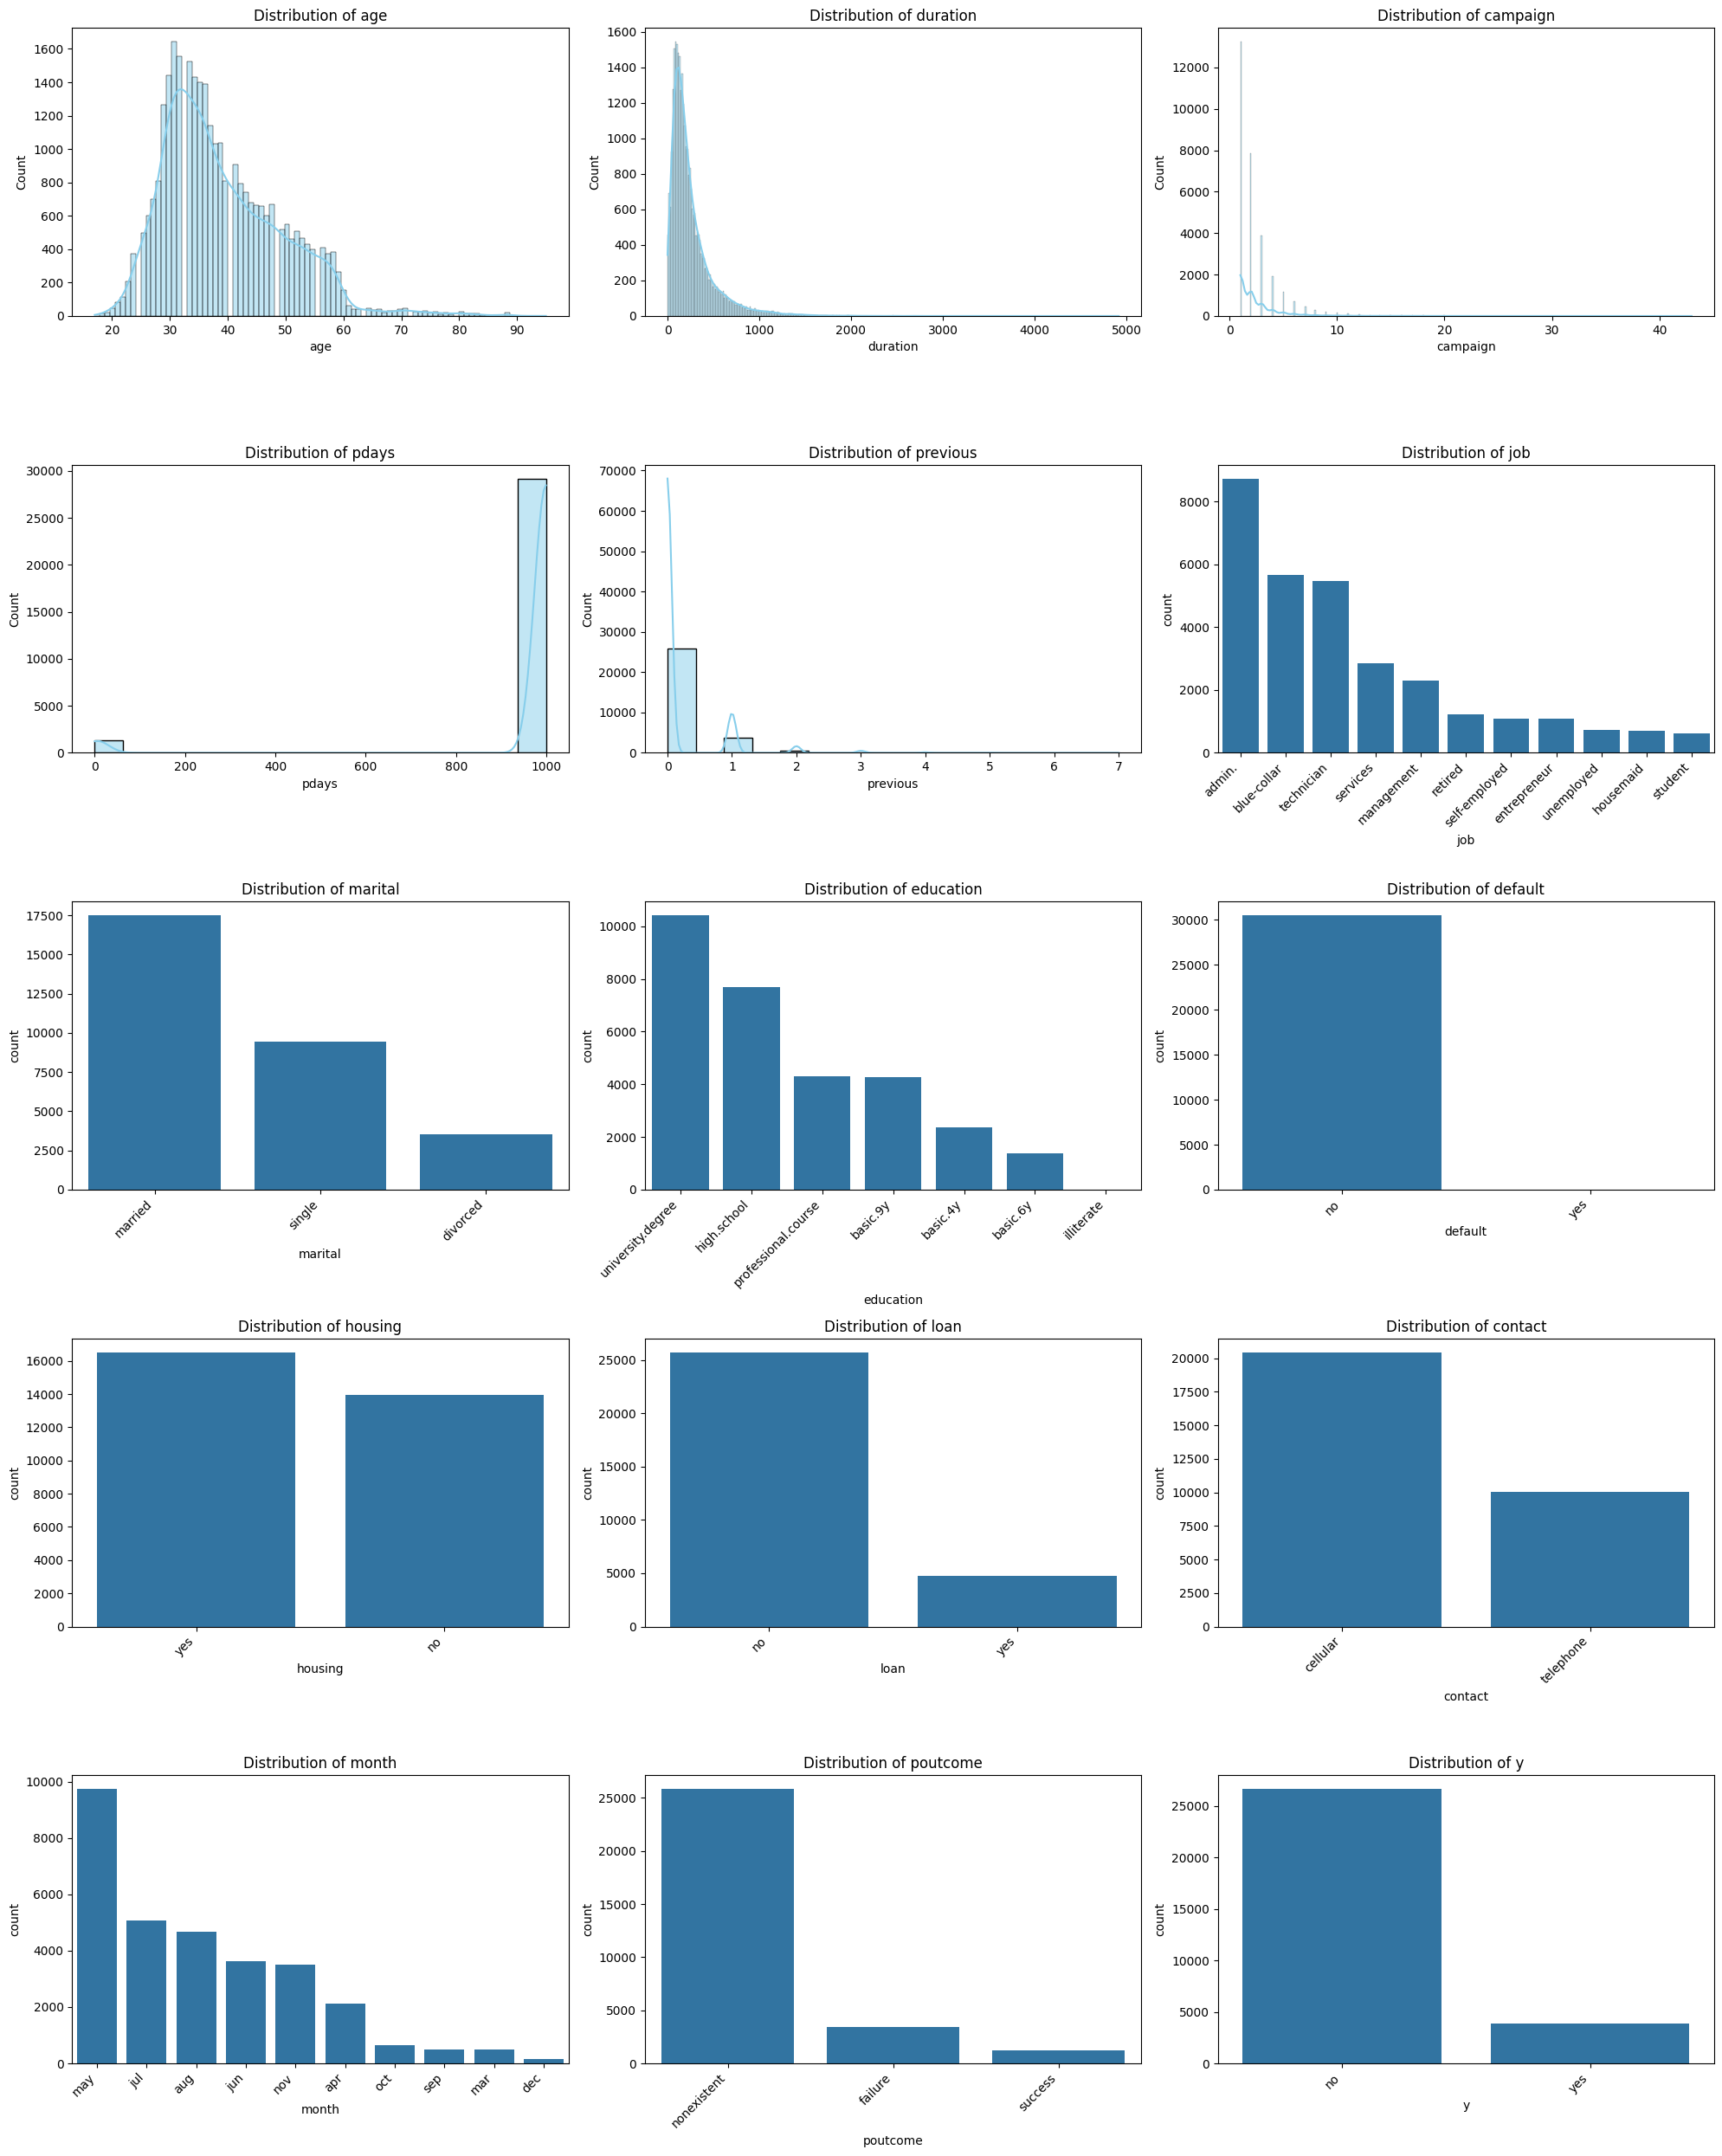

In [9]:
# Identify numeric and categorical columns
numeric_cols = ['age', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

# Set up the grid size
total_cols = numeric_cols + categorical_cols
n_cols = 3  # number of columns in the grid
n_rows = (len(total_cols) + n_cols - 1) // n_cols  # auto-calculate rows

plt.figure(figsize=(20, n_rows * 5))  # adjust figure size

for idx, col in enumerate(total_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    
    if col in numeric_cols:
        sns.histplot(test_df[col], kde=True, color='skyblue')
    else:
        order = test_df[col].value_counts().index  # sort bars by frequency
        sns.countplot(x=col, data=test_df, order=order)
        plt.xticks(rotation=45, ha='right')
        
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.savefig("plots/distribution-plots-newds.png")
plt.show()

In [10]:
test_df['duration_boxcox'], lambda_val = stats.boxcox(test_df['duration'] + 0.1)

In [11]:
test_df['campaign_cbrt'] = np.cbrt(test_df['campaign'])

In [12]:
test_df['pdays_special'] = (test_df['pdays'] == -1).astype(int)
test_df['pdays_transformed'] = np.log(test_df['pdays'] + 1)


In [13]:
test_df['had_previous'] = (test_df['previous'] > 0).astype(int)

In [14]:
test_df['age_scaled'] = StandardScaler().fit_transform(test_df[['age']])

In [15]:
test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'], drop_first=True)

In [16]:
# Map months to numbers
month_mapping = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 
                 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
test_df['month_num'] = test_df['month'].map(month_mapping)

# Create cyclical features
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month_num']/12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month_num']/12)

In [17]:
columns_to_drop = [
    'age', 'duration', 'campaign', 'pdays', 'previous','month',
]
test_df = test_df.drop(columns=columns_to_drop)

In [18]:
yes_no_map = {'yes': True, 'no': False}

for col in ['default', 'housing', 'loan', 'y']:
    test_df[col] = test_df[col].map(yes_no_map)

In [19]:
test_df.dtypes

default                             bool
housing                             bool
loan                                bool
y                                   bool
duration_boxcox                  float64
campaign_cbrt                    float64
pdays_special                      int64
pdays_transformed                float64
had_previous                       int64
age_scaled                       float64
job_blue-collar                     bool
job_entrepreneur                    bool
job_housemaid                       bool
job_management                      bool
job_retired                         bool
job_self-employed                   bool
job_services                        bool
job_student                         bool
job_technician                      bool
job_unemployed                      bool
marital_married                     bool
marital_single                      bool
education_basic.6y                  bool
education_basic.9y                  bool
education_high.s

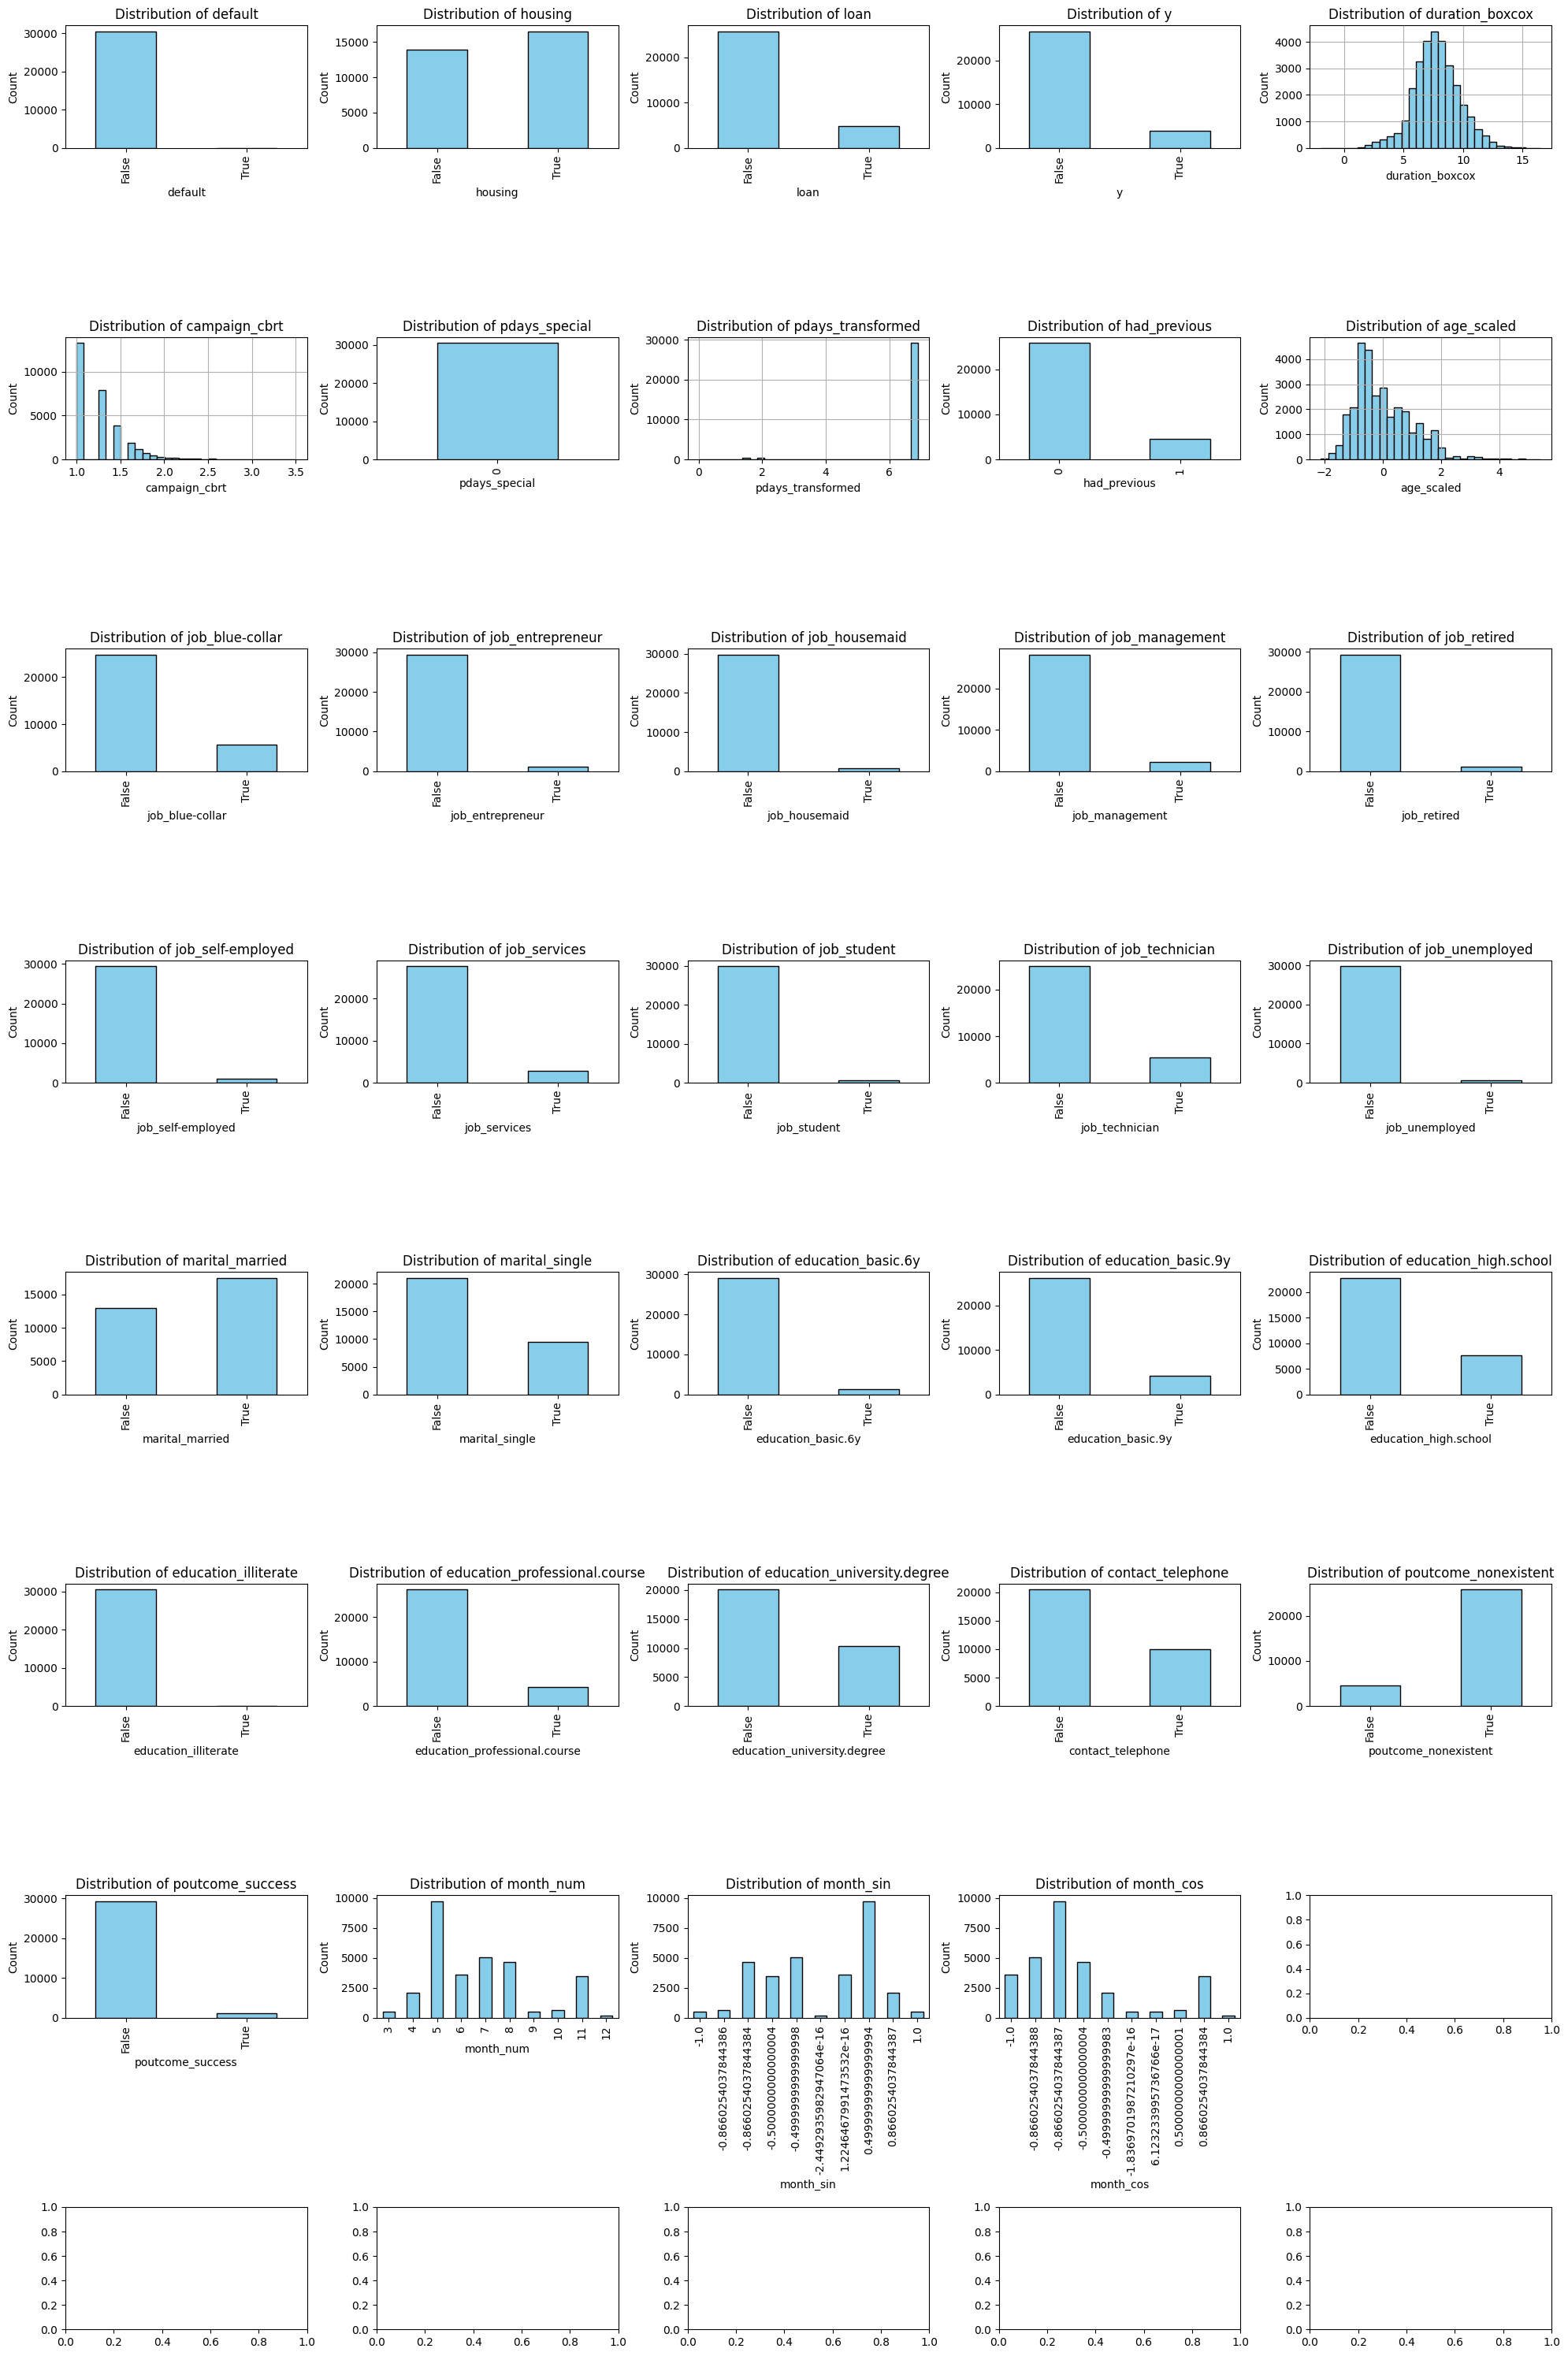

In [20]:
fig, axes = plt.subplots(8, 5, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(test_df.columns):
    if test_df[col].nunique() > 10:
        test_df[col].hist(bins=30, ax=axes[i], color='skyblue', edgecolor='black')
    else:
        test_df[col].value_counts().sort_index().plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig("plots/distribution-plots-newds.png")
plt.show()

In [21]:
test_df.to_csv("../data/processed/bank-dataset-additional-processed-skewness.csv")